<a href="https://colab.research.google.com/github/lattytytyty-web/Ge337-PROGRAMMING-DEVELOPMENT-FOR-GEOSPATIAL-DATA-ANALYSIS/blob/main/Lab_2_%E0%B8%A3%E0%B8%B1%E0%B8%95%E0%B8%95%E0%B8%B4%E0%B8%A2%E0%B8%B2_6606614813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geemap geopandas folium rasterio

import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00


In [2]:
# =========================
# ติดตั้ง Earth Engine
# =========================
!pip install earthengine-api

# =========================
# เรียกใช้งาน Earth Engine
# =========================
import ee

# ล็อกอิน
ee.Authenticate()

# =========================
# Initialize ด้วย project ของคุณ
# =========================
ee.Initialize(project='ee-lattytytyty')

print("Earth Engine initialized successfully!")

Earth Engine initialized successfully!


In [3]:
# โหลดขอบเขตจังหวัดประเทศไทย
thailand = ee.FeatureCollection("FAO/GAUL/2015/level1")

# เลือกจังหวัดกาญจนบุรี
kan = thailand.filter(ee.Filter.eq('ADM1_NAME', 'Kanchanaburi'))

# แปลงเป็น geometry
roi = kan.geometry()

In [4]:
sentinel = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(roi)
    .filterDate('2024-01-01', '2024-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .select(['B2', 'B3', 'B4', 'B8']) # Select only the bands needed for RGB and NDVI
    .median()
    .clip(roi)
)

/usr/local/lib/python3.12/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [5]:
info = sentinel.getInfo()

print("Bands:", [band['id'] for band in info['bands']])
print("CRS:", info['bands'][0]['crs'])
print("Resolution:", sentinel.select('B2').projection().nominalScale().getInfo())

Bands: ['B2', 'B3', 'B4', 'B8']
CRS: EPSG:4326
Resolution: 111319.49079327357


In [6]:
ndvi = sentinel.normalizedDifference(['B8', 'B4']).rename('NDVI')

In [7]:
Map = geemap.Map(center=[14.5, 99.0], zoom=8)

rgb = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

Map.addLayer(sentinel, rgb, 'Sentinel-2 RGB')

ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

Map.addLayer(ndvi, ndvi_vis, 'NDVI')
Map.addLayer(kan, {}, 'Kanchanaburi boundary')

Map

Map(center=[14.5, 99.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [8]:
import geopandas as gpd
from shapely.geometry import Point

# =========================
# รายชื่อสถานี จังหวัดกาญจนบุรี จาก https://www.cmuccdc.org/air-quality-information
# =========================
names = [
    "สถานี 1 ที่ว่าการอำเภอทองผาภูมิ (กอ.รมน.กาญจนบุรี) จังหวัดกาญจนบุรี",
    "สถานี 2 วิทยาลัยอาชีวศึกษากาญจนบุรี ตำบลบ้านเหนือ อำเภอเมือง จังหวัดกาญจนบุรี",
    "สถานี 3 ศูนย์วิจัยโรคเขตร้อน มหาวิทยาลัยมหิดล จังหวัดกาญจนบุรี",
    "สถานี 4 สสอ.ท่ามะกา ตำบลท่ามะกา อำเภอท่ามะกา จังหวัดกาญจนบุรี",
    "สถานี 5 สสอ.ท่าม่วง ตำบลท่าม่วง อำเภอท่าม่วง จังหวัดกาญจนบุรี",
    "สถานี 6 สสอ.บ่อพลอย ตำบลบ่อพลอย อำเภอบ่อพลอย จังหวัดกาญจนบุรี",
    "สถานี 7 สสอ.พนมทวน ตำบลพนมทวน อำเภอพนมทวน จังหวัดกาญจนบุรี",
    "สถานี 8 สสอ.หนองปรือ ตำบลหนองปรือ อำเภอหนองปรือ จังหวัดกาญจนบุรี",
    "สถานี 9 สสอ.ห้วยกระเจา ตำบลห้วยกระเจา อำเภอห้วยกระเจา จังหวัดกาญจนบุรี",
    "สถานี 10 สสอ.เลาขวัญ ตำบลเลาขวัญ อำเภอเลาขวัญ จังหวัดกาญจนบุรี",
    "สถานี 11 สสอ.ไทรโยค ตำบลลุ่มสุ่ม อำเภอไทรโยค จังหวัดกาญจนบุรี",
    "สถานี 12 เขื่อนวชิราลงกรณ ตำบลท่าขนุน อำเภอทองผาภูมิ จังหวัดกาญจนบุรี"
]

# =========================
# พิกัด (longitude, latitude)
# =========================
lons = [
    98.6406, 99.5340, 99.5185, 99.7664,
    99.6412, 99.5153, 99.7006, 99.3531,
    99.6560, 99.7742, 98.9816, 98.5932
]

lats = [
    14.7432, 14.0226, 14.0450, 13.9608,
    13.9576, 14.3235, 14.1303, 14.6380,
    14.3045, 14.5946, 14.4093, 14.7965
]

# =========================
# สร้าง Geometry
# =========================
geometry = [Point(x, y) for x, y in zip(lons, lats)]

points = gpd.GeoDataFrame(
    {"name": names},
    geometry=geometry,
    crs="EPSG:4326"
)

points

,name,geometry
0,สถานี 1 ที่ว่าการอำเภอทองผาภูมิ (กอ.รมน.กาญจนบ...,POINT (98.6406 14.7432)
1,สถานี 2 วิทยาลัยอาชีวศึกษากาญจนบุรี ตำบลบ้านเห...,POINT (99.534 14.0226)
2,สถานี 3 ศูนย์วิจัยโรคเขตร้อน มหาวิทยาลัยมหิดล ...,POINT (99.5185 14.045)
3,สถานี 4 สสอ.ท่ามะกา ตำบลท่ามะกา อำเภอท่ามะกา จ...,POINT (99.7664 13.9608)
4,สถานี 5 สสอ.ท่าม่วง ตำบลท่าม่วง อำเภอท่าม่วง จ...,POINT (99.6412 13.9576)
5,สถานี 6 สสอ.บ่อพลอย ตำบลบ่อพลอย อำเภอบ่อพลอย จ...,POINT (99.5153 14.3235)
6,สถานี 7 สสอ.พนมทวน ตำบลพนมทวน อำเภอพนมทวน จังห...,POINT (99.7006 14.1303)
7,สถานี 8 สสอ.หนองปรือ ตำบลหนองปรือ อำเภอหนองปรื...,POINT (99.3531 14.638)
8,สถานี 9 สสอ.ห้วยกระเจา ตำบลห้วยกระเจา อำเภอห้ว...,POINT (99.656 14.3045)
9,สถานี 10 สสอ.เลาขวัญ ตำบลเลาขวัญ อำเภอเลาขวัญ ...,POINT (99.7742 14.5946)


In [9]:
stations = points.copy()

In [10]:
Map.add_gdf(stations, layer_name="Air Quality Stations")
Map

Map(center=[14.5, 99.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [11]:
def get_ndvi_value(point):
    geom = ee.Geometry.Point(point.x, point.y)
    value = ndvi.sample(geom, 10).first()
    return value.get('NDVI').getInfo()

stations['NDVI'] = stations.geometry.apply(get_ndvi_value)

stations.head()

,name,geometry,NDVI
0,สถานี 1 ที่ว่าการอำเภอทองผาภูมิ (กอ.รมน.กาญจนบ...,POINT (98.6406 14.7432),0.410331
1,สถานี 2 วิทยาลัยอาชีวศึกษากาญจนบุรี ตำบลบ้านเห...,POINT (99.534 14.0226),0.028294
2,สถานี 3 ศูนย์วิจัยโรคเขตร้อน มหาวิทยาลัยมหิดล ...,POINT (99.5185 14.045),0.097118
3,สถานี 4 สสอ.ท่ามะกา ตำบลท่ามะกา อำเภอท่ามะกา จ...,POINT (99.7664 13.9608),0.142218
4,สถานี 5 สสอ.ท่าม่วง ตำบลท่าม่วง อำเภอท่าม่วง จ...,POINT (99.6412 13.9576),0.422754


In [12]:
ndvi_np = geemap.ee_to_numpy(ndvi, region=roi, scale=500)

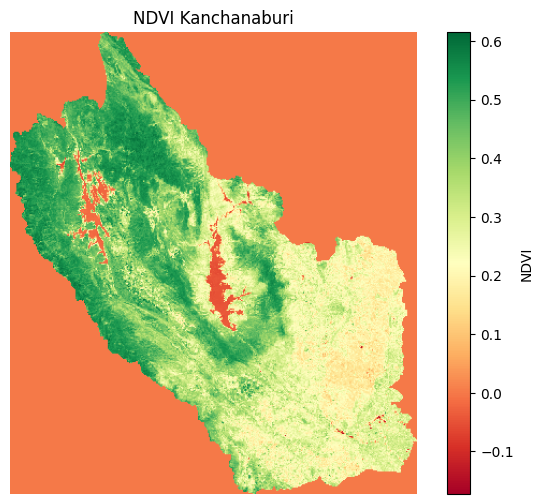

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(ndvi_np, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('NDVI Kanchanaburi')
plt.axis('off')
plt.show()

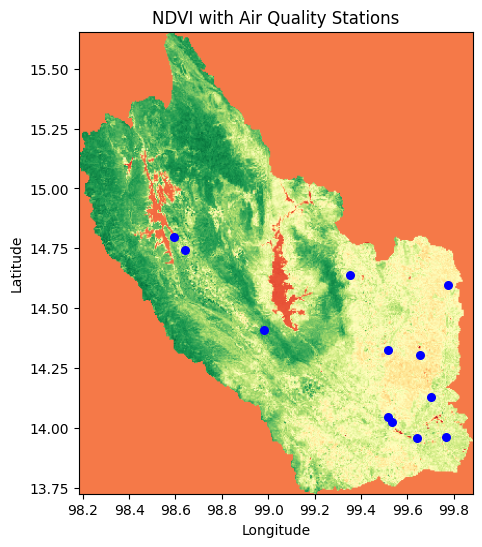

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

# ดึงขอบเขตจาก ROI
bounds = roi.bounds().getInfo()['coordinates'][0]

xmin = bounds[0][0]
ymin = bounds[0][1]
xmax = bounds[2][0]
ymax = bounds[2][1]

# แสดง NDVI พร้อม extent จริง
ax.imshow(
    ndvi_np,
    cmap='RdYlGn',
    extent=[xmin, xmax, ymin, ymax],
    origin='upper'
)

# plot จุดสถานี
stations.plot(ax=ax, color='blue', markersize=30)

plt.title('NDVI with Air Quality Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## **คำถามท้าย Lab**

**1. ข้อดีและข้อเสียของ Matplotlib และ Folium ในการแสดงผลข้อมูลเชิงพื้นที่คืออะไร?**

-Matplotlib เหมาะสำหรับการสร้างแผนที่แบบภาพนิ่งที่สามารถปรับแต่งรายละเอียดได้มากและเหมาะสำหรับงานวิเคราะห์เชิงวิชาการ ในขณะที่ Folium เหมาะสำหรับการสร้างแผนที่แบบโต้ตอบที่สามารถซูมและเลื่อนดูได้ แต่มีข้อจำกัดด้านการปรับแต่งรูปแบบเชิงลึก

**2. ทำไมต้องใช้ Masking และ Clipping ในการวิเคราะห์ข้อมูลภาพถายดาวเทียม**

-Masking และ Clipping ช่วยให้การวิเคราะห์ข้อมูลภาพถ่ายดาวเทียมเฉพาะพื้นที่ที่สนใจ ลดข้อมูลส่วนเกิน และเพิ่มความแม่นยำในการวิเคราะห์

**3. ค่า NDVI บ่งบอกอะไร และสามารถใช้ในการวิเคราะห์อะไรได้บ้าง?**

-NDVI เป็นดัชนีที่ใช้วัดความสมบูรณ์ของพืชพรรณ โดยค่าที่สูงแสดงถึงพืชที่มีสุขภาพดีและหนาแน่น สามารถใช้วิเคราะห์พื้นที่ป่า การเกษตร และการเปลี่ยนแปลงสิ่งแวดล้อมได้

**4. การแปลงค่าพิกัด CRS มีความสำคัญอย่างไรในการทงานกับเวกเตอร์และแรสเตอร**

-CRS มีความสำคัญในการทำให้ข้อมูลเวกเตอร์และแรสเตอร์อยู่ในระบบพิกัดเดียวกัน เพื่อให้สามารถวิเคราะห์ร่วมกันได้อย่างถูกต้อง

**5. หากต้องการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียมในช่วงเวลาต่างๆ ( Time Series )ควรทำอย่างไร**

-สามารถใช้ข้อมูลภาพถ่ายดาวเทียมหลายช่วงเวลา แล้วเปรียบเทียบค่าดัชนี เช่น NDVI ในแต่ละช่วงเวลา เพื่อศึกษาการเปลี่ยนแปลงพื้นที่